# Kernel-based Tracking in Joint Feature-Spatial Space

# 实验环境
* opencv
* numpy

In [2]:
import sys
sys.path.append('./')

In [3]:
import numpy as np
import cv2
from main import *

根据距离-特征联合空间的相似性度量

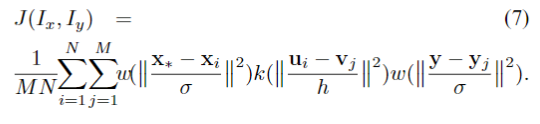

推导均值漂移的优化算法，得到的目标质心估计方程如下\
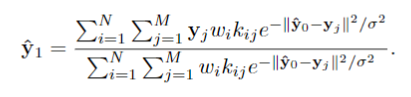\
其中，M和N为目标模板内的像素点数，鉴于循环的时间开销较大，编程时尽可能的采用矩阵运算来降低运算复杂度，详细代码如下

In [4]:
def meanshift(img,obj,sigma,h,y_pos,its =0):
    '''
    均值漂移算法
    img: 原图像
    obj: 目标模板
    sigma: 高斯核标准差
    h: 高斯核标准差
    y_pos: 目标模板旧位置
    its: 迭代次数
    
    return: 目标模板新位置
    
    '''
    height, weight = obj.shape[:2]
    y_leftup = np.array([y_pos[0]-height//2, y_pos[1]-weight//2])
    roi_y = img[y_pos[0]-height//2:y_pos[0] +
                height//2, y_pos[1]-weight//2:y_pos[1]+weight//2]
    # 模板中心
    xc = np.array([obj.shape[0]//2, obj.shape[1]//2])
    sum1 = 0
    sum2 = 0
    # 计算高斯核，预先存储高斯矩阵
    x_pts = np.meshgrid(np.arange(weight),np.arange(height))
    omega = (x_pts[0]-xc[1])**2+(x_pts[1]-xc[0])**2
    omega = np.exp(-omega/(2*sigma*sigma))
    y_pts = [x_pts[0]+y_leftup[1],x_pts[1]+y_leftup[0]]
    g = (y_pts[0]-y_pos[1])**2+(y_pts[1]-y_pos[0])**2
    g = np.exp(-g/(2*sigma*sigma))
    # 计算新位置，采用矩阵运算降低运算时间
    for i in range(height):
        for j in range(weight):
            k = (obj[i,j,:]-roi_y)**2
            k = k.sum(axis=2).astype(np.float64)
            k = np.exp(-k/(2*h*h))
            sum1 = sum1 + omega[i,j]*np.sum(np.sum(g*k*y_pts,axis=1),axis=1)
            sum2 = sum2 + omega[i,j]*np.sum(np.sum(g*k))
    y_newpos = np.round(sum1/sum2).astype(np.int16)[::-1]
    # 判断是否收敛
    if np.linalg.norm(y_newpos-y_pos) < 0.5 or its >= 10:
        print("iteration times: ",its)
        return y_newpos
    else: 
        y_newpos = meanshift(img, obj, sigma, h, y_newpos, its+1)
        return y_newpos

In [ ]:
video = cv2.VideoCapture('1.avi')

# 第一帧截取目标
ret, frame = video.read()
# 选择ROI
roi = cv2.selectROI(frame)
y_pos = np.array([roi[1]+roi[3]//2, roi[0]+roi[2]//2])
roi = frame[int(roi[1]):int(roi[1]+roi[3]//2*2),
            int(roi[0]):int(roi[0]+roi[2]//2*2)]
cv2.imshow('roi', roi)
print('roi shape: ', roi.shape)
n = 0
while True:
    ret, frame = video.read()
    if not ret:
        cv.destroyAllWindows()
        break
    if n == 0:
        n = n+1
        continue
    y_pos = meanshift(frame, roi,5, 5, y_pos)
    # 画矩形框
    cv2.rectangle(frame, (int(y_pos[1]-roi.shape[1]//2), int(y_pos[0]-roi.shape[0]//2)),
                    (int(y_pos[1]+roi.shape[1]//2), int(y_pos[0]+roi.shape[0]//2)), (0, 255, 0), 2)
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) == ord('q'):
        cv2.destroyAllWindows()
        break

# 实验结论和结果
通过实验发现sigma和h的取值会极大地影响追踪器的性能，sigma和h的大小控制模板图像和当前帧之间相似性度量的敏感度，比如sigma越大时，远端点对目标质心的加权越大，追踪器注意的空间越大，h越大时，追踪器对相邻帧之间的变化越不敏感。这就导致在实际应用中，sigma和h的值可能需要根据实际情况频繁调整来达到最佳的跟踪性能，作者也在论文中提到，这并不是一个最优的解决方案，仍需进行改进来实现自适应的sigma和h值；在本次实验所用的视频中，经过多次实验，发现$(sigma,h)=(5,5)$时追踪性能最佳，实验结果如下：（其中蓝色矩形框表示初始帧框定的目标，绿色框为跟踪器的估计值）

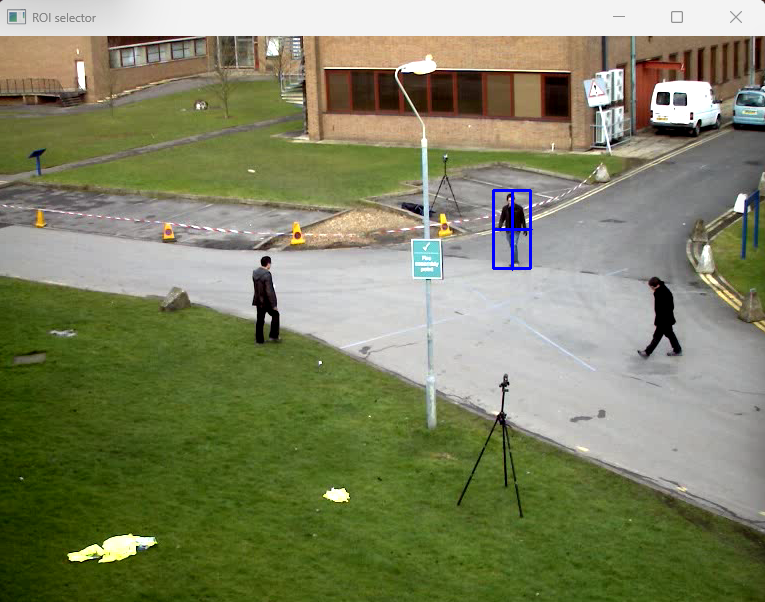
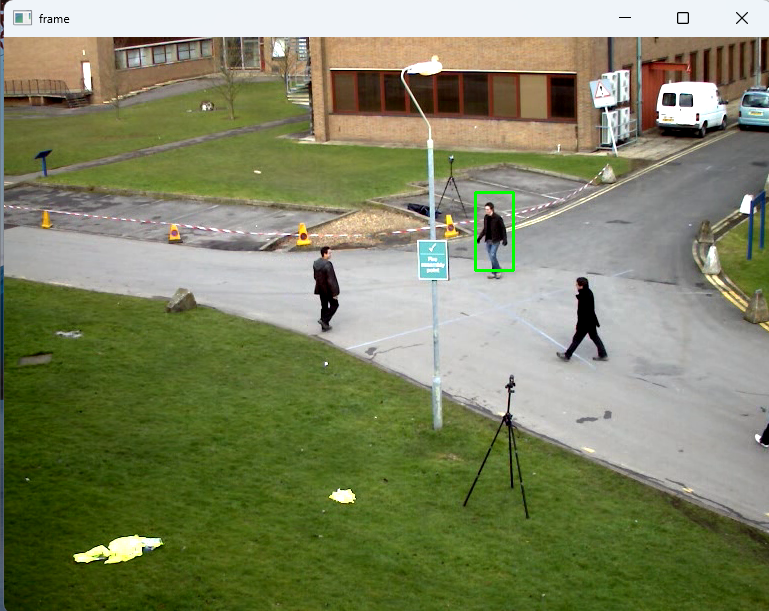
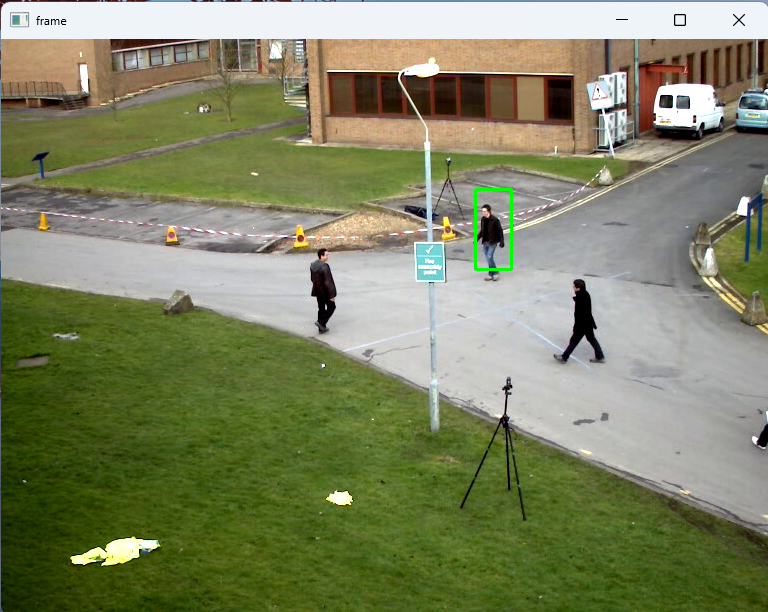
![image-4.png](attachment:image-4.png)
![image-4.png](attachment:image-4.png)

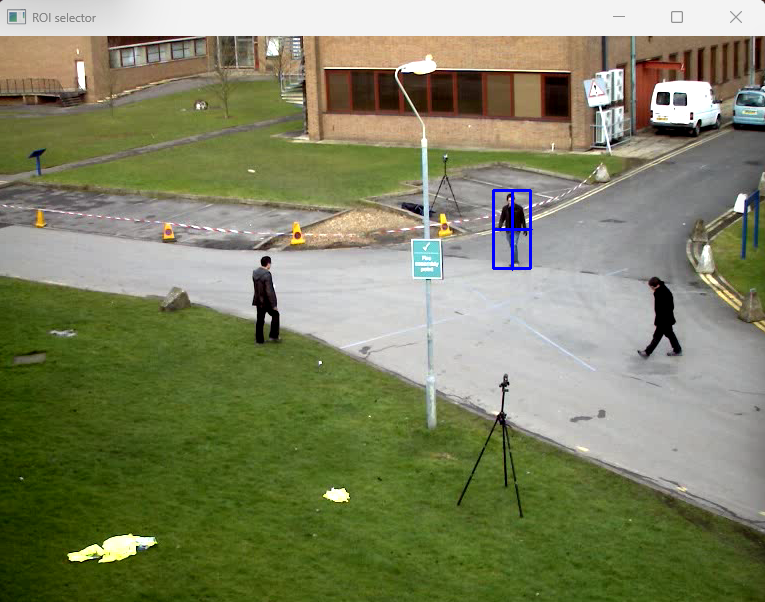
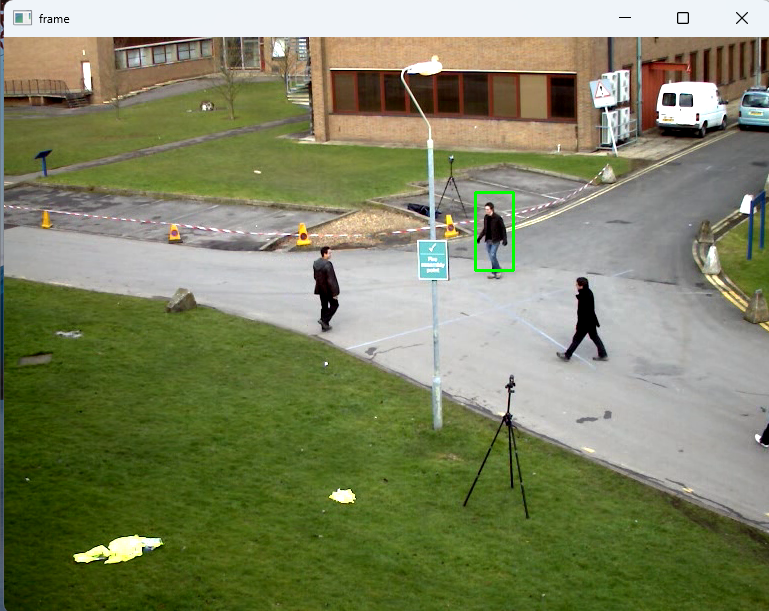
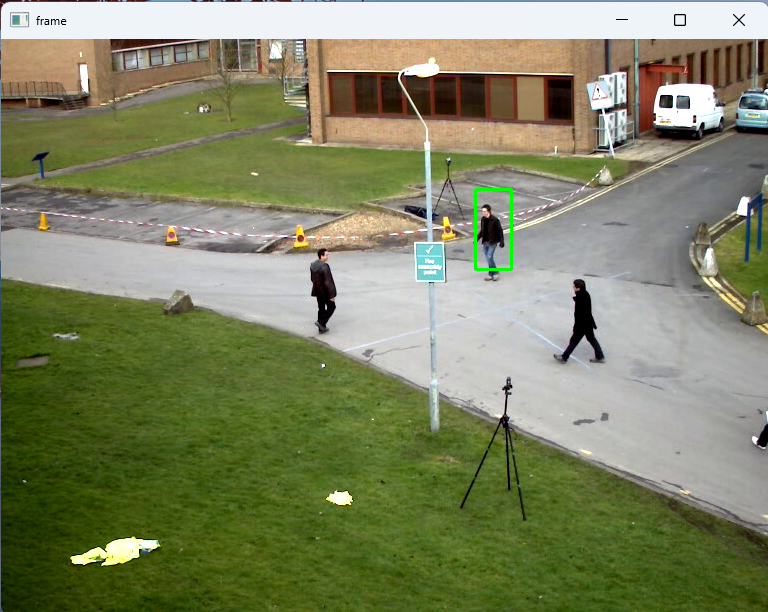
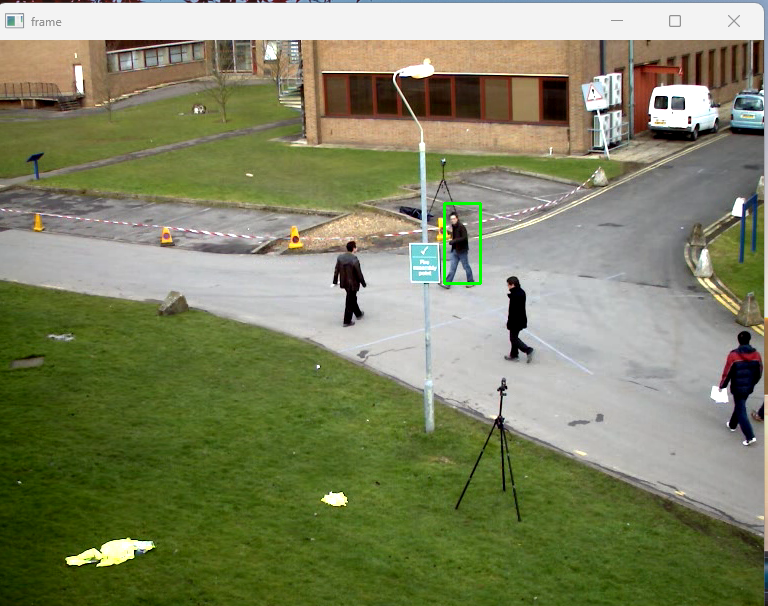

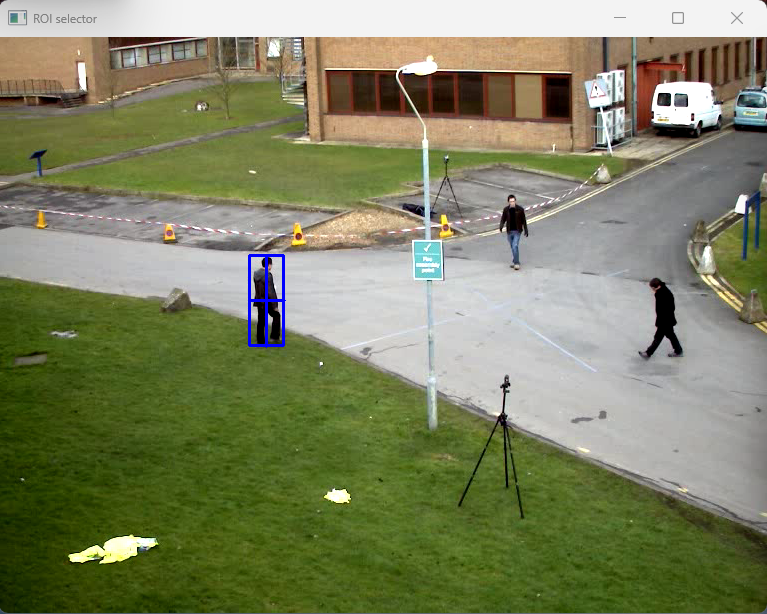
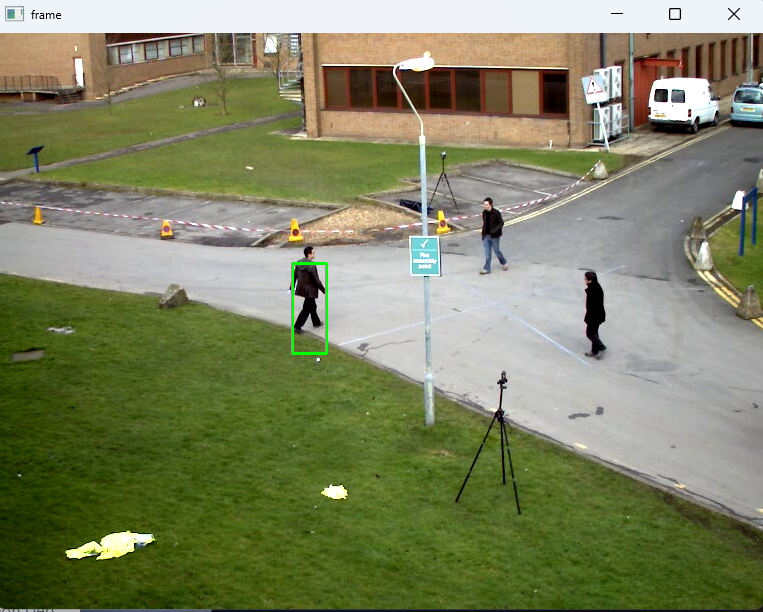
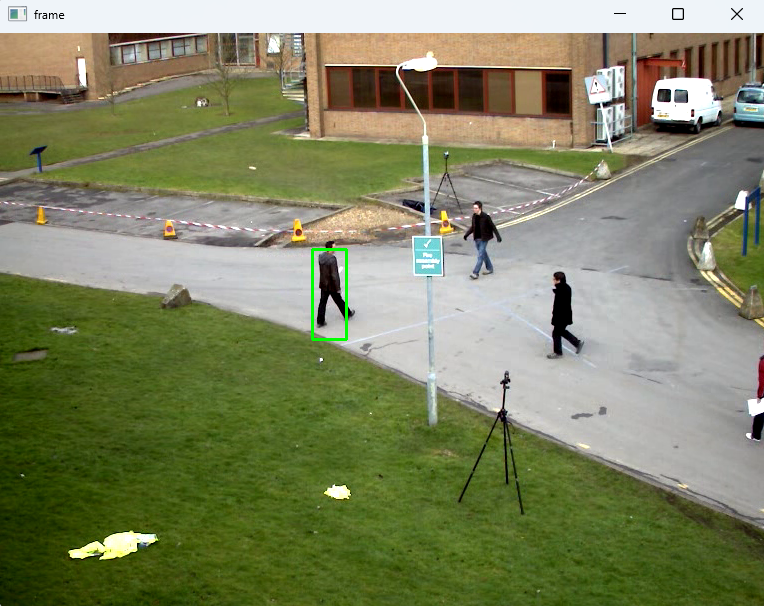
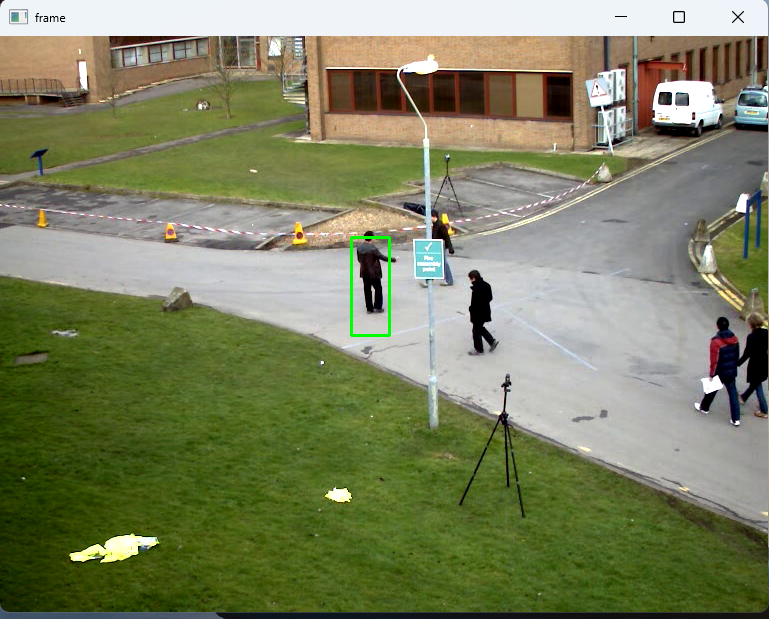